In [261]:
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.ensemble import GradientBoostingSurvivalAnalysis, RandomSurvivalForest
from sklearn.model_selection import train_test_split
from lifelines.utils import concordance_index
import numpy as np
import pandas as pd
import random
def compare_models(X, y):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
    

    # Initialize the GBST survival regressor
    gbst = GradientBoostingSurvivalAnalysis(n_estimators=100, random_state=20)
    # Fit the model to the training data
    gbst.fit(X_train, y_train)
    # Predict the survival times for the testing data
    survival_times_gbst = gbst.predict(X_test)

    # Create an instance of the RandomSurvivalForest model
    rsf = RandomSurvivalForest(n_estimators=100, random_state=20)
    # Fit the model on the training data
    rsf.fit(X_train, y_train)
    # Predict the survival times for the testing data
    survival_times_rsf = rsf.predict(X_test)

    # Prepare the target variable for CoxPHSurvivalAnalysis
    y_coxph = np.array(list(zip(y_train['event'], y_train['time'])), dtype=[('event', bool), ('time', float)])

    # Create an instance of the CoxPHSurvivalAnalysis model with regularization
    coxph = CoxPHSurvivalAnalysis(alpha=1e-9)
    # Fit the model on the training data
    coxph.fit(X_train, y_coxph)
    # Predict the survival times for the testing data
    survival_times_coxph = coxph.predict(X_test)

    # Compute the concordance index to evaluate the model performance
    c_index_gradient = concordance_index(y_test['time'], -survival_times_gbst, y_test['event'])
    c_index_rf = concordance_index(y_test['time'], -survival_times_rsf, y_test['event'])
    c_index_coxph = concordance_index(y_test['time'], -survival_times_coxph, y_test['event'])

    return {
        "gradient": c_index_gradient,
        "random_survival": c_index_rf,
        "coxph": c_index_coxph,
        'coxfitter': c_index_mean
}


In [262]:

data = pd.read_csv('IFR_Extract_with_selected_columns_15-5-23.csv')

obreak_date = pd.to_datetime(data.obreak_date)
datebone = pd.to_datetime(data.datebone)
y = ( abs( datebone - obreak_date))
X = data.drop(["obreak_date","datebone"],axis=1)
selectedColumns = [ 'PatientAge', "PatientGender",'parentbreak', 'alcohol',
                'arthritis', 'diabetes',
                'oralster', 'smoke', 'obreak','ptunsteady','obreak_hip','marital','whereliv','ptfall','obreak_frac_count','specialistReferral','fpp_info','obreak_spine','obreak_pelvis']
dropList = []
for i in data:
    if data[i].dtypes == 'O':
        dropList.append(data[i].name)
dropList.append("CompletedSurveyId")
dropList.append("PatientId")
X = data.drop(dropList,axis=1)
X.fillna(0,inplace=True)
y = pd.DataFrame({"time":y})

y['event'] = y.time.apply(lambda x: x.days != 0 )
structured_array = y.to_records(index=False)

swapped = pd.DataFrame({
    "event": y.event,
    "time": y.time.apply(lambda x: x.days)
})
(swapped.event).value_counts()
swapped.event = swapped.event.astype(bool)
structured_array = np.rec.array(swapped.to_records(index=False))

mergedBeforeEncoding = pd.concat([X[selectedColumns],swapped],axis=1)
mergedBeforeEncoding
data['whereliv'].value_counts()

2.0    451
1.0    232
4.0     40
3.0     29
7.0     13
6.0      4
Name: whereliv, dtype: int64

In [263]:
import random
# Define the number of synthetic samples
num_samples = 0

# Get the column types for each column in mergedBeforeEncoding
column_types = {}
for column in mergedBeforeEncoding.columns:
    column_types[column] = mergedBeforeEncoding[column].dtype

# Shuffle the feature names
feature_names = list(mergedBeforeEncoding.columns)
random.shuffle(feature_names)

# Initialize an empty DataFrame to store the selected features and their performance
selected_features = pd.DataFrame(columns=["Feature"])

# Create a synthetic data DataFrame with the same columns as mergedBeforeEncoding
synthetic_data = pd.DataFrame(columns=mergedBeforeEncoding.columns)

# Generate synthetic data for each feature
for feature in feature_names:
    column_type = column_types[feature]

    if column_type == bool:
        synthetic_data[feature] = np.random.choice([False, True], size=num_samples)
    else:
        # Sample values from the existing data to maintain the distribution
        existing_data_values = mergedBeforeEncoding[feature].dropna().values
        synthetic_data[feature] = np.random.choice(existing_data_values, size=num_samples)

    synthetic_data[feature] = synthetic_data[feature].astype(column_type)

# Add additional columns to the synthetic data
synthetic_data["obreak"] = 1
synthetic_data["event"] = False
synthetic_data["time"] = 0

augmented_data = pd.concat([mergedBeforeEncoding, synthetic_data], ignore_index=True)



# Store the selected features
selected_features["Feature"] = feature_names

cat_features = ['parentbreak', 'alcohol',
                'oralster', 'smoke','ptunsteady','marital','whereliv','ptfall','obreak_frac_count','specialistReferral','fpp_info','obreak_spine','obreak_pelvis'
                # These features were determined to apply minimal impact even
                # 'respdisease', 'hbp','heartdisease',
                # 'ptunsteady', 'wasfractdue2fall', 'cholesterol',
                # 'ptfall', 'shoulder', 'wrist', 'bmdtest_10yr_caroc'
                ]

for feature in cat_features:
    if augmented_data is not None:
        if feature in augmented_data.columns:
            cat_one_hot = pd.get_dummies(augmented_data[feature], prefix=f'{feature}', drop_first=False)
            augmented_data = augmented_data.drop(feature, axis=1)
            augmented_data = augmented_data.join(cat_one_hot)
            
X = augmented_data.drop(['event','time'],axis=1)
y = augmented_data[['event','time']]

y = np.rec.array(y.to_records(index=False))
data['marital'].value_counts()

2.0    343
6.0    218
1.0     81
5.0     60
8.0     20
3.0     17
4.0     11
7.0      8
Name: marital, dtype: int64

In [264]:
import itertools
feature_comparisons = {
    'gradient':'',
    'random_survival':'',
    'coxph':''
    
}
def explore_feature_combinations(X, y, max_iterations=8000):
    best_features = []
    best_performance = 0
    best_model_name = ""

    current_features = set()
    remaining_features = set(X.columns)

    while remaining_features:
        performance_gain = False
        best_gain = 0
        best_feature = None

        for feature in remaining_features:
            features_to_try = current_features | {feature}
            X_subset = X[list(features_to_try)]
            outcome = compare_models(X_subset, y)

            if outcome['gradient'] > best_performance:
                gain = outcome['gradient'] - best_performance
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_model_name = 'gradient'
                    feature_comparisons['gradient'] = outcome['gradient']
                    feature_comparisons['random_survival'] = outcome['random_survival']
                    feature_comparisons['coxph'] = outcome['coxph']

            if outcome['random_survival'] > best_performance:
                gain = outcome['random_survival'] - best_performance
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_model_name = 'random_survival'
                    feature_comparisons['gradient'] = outcome['gradient']
                    feature_comparisons['random_survival'] = outcome['random_survival']
                    feature_comparisons['coxph'] = outcome['coxph']

            if outcome['coxph'] > best_performance:
                gain = outcome['coxph'] - best_performance
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_model_name = 'coxph'
                    feature_comparisons['gradient'] = outcome['gradient']
                    feature_comparisons['random_survival'] = outcome['random_survival']
                    feature_comparisons['coxph'] = outcome['coxph']
            
        if best_feature is not None:
            current_features.add(best_feature)
            remaining_features.remove(best_feature)
            best_performance += best_gain
            performance_gain = True

        if not performance_gain or len(current_features) >= max_iterations:
            break

    return best_model_name, list(current_features), best_performance

# Call the function with a maximum of iterations equal to the total number of features
best_model_name, best_features, best_performance = explore_feature_combinations(X, y, max_iterations=len(X.columns))

print("Best feature combination:", best_features)
print("Highest C-index:", best_performance)
print("Best Model:", best_model_name)
for key,(i,j) in enumerate(feature_comparisons.items()):
    print(i,j)

Best feature combination: ['whereliv_1.0', 'ptfall_1', 'fpp_info_3', 'whereliv_2.0', 'ptunsteady_2', 'specialistReferral_2', 'whereliv_6.0']
Highest C-index: 0.6670240310704749
Best Model: coxph
gradient 0.6423658872077029
random_survival 0.6458957035358848
coxph 0.6670240310704749


In [265]:
from lifelines import CoxPHFitter

selected_data = pd.concat([X,pd.DataFrame(y)],axis=1)
best_features

['whereliv_1.0',
 'ptfall_1',
 'fpp_info_3',
 'whereliv_2.0',
 'ptunsteady_2',
 'specialistReferral_2',
 'whereliv_6.0']

In [266]:
from lifelines import CoxPHFitter
from lifelines.utils import k_fold_cross_validation
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
import numpy as np

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform LASSO feature selection
lasso = LassoCV(cv=5)
lasso.fit(X_scaled, y['time'])
selected_features = lasso.coef_ != 0

# Filter the selected feature names
feature_names = X.columns[selected_features].tolist()

# Create a DataFrame with selected features
selected_data = pd.DataFrame(X_scaled[:, selected_features], columns=feature_names)
selected_data['event'] = y['event']
selected_data['time'] = y['time']

# Drop columns with low variance
selected_data = selected_data.drop(['smoke_3'], axis=1)

# Fit CoxPH model on the selected features
cph = CoxPHFitter()
cph.fit(selected_data, duration_col='time', event_col='event')

# Assess model performance using cross-validation
c_index_values = k_fold_cross_validation(cph, selected_data, duration_col='time', event_col='event', k=5, scoring_method='concordance_index')
c_index_mean = np.mean(c_index_values)
print("Cross-validated C-index: {:.3f}".format(c_index_mean))
# Get the first feature name as the covariate
covariate = feature_names[0]

# Plot the partial effects for all features
cph.plot()


/Users/ofir/anaconda3/lib/python3.10/site-packages/lifelines/fitters/coxph_fitter.py:1676: RuntimeWarning: overflow encountered in exp
  scores = weights * exp(dot(X, beta))
/Users/ofir/anaconda3/lib/python3.10/site-packages/lifelines/fitters/coxph_fitter.py:1728: RuntimeWarning: divide by zero encountered in divide
  denom = 1.0 / np.array([risk_phi])
/Users/ofir/anaconda3/lib/python3.10/site-packages/lifelines/fitters/coxph_fitter.py:1730: RuntimeWarning: invalid value encountered in multiply
  a1 = risk_phi_x_x * denom
/Users/ofir/anaconda3/lib/python3.10/site-packages/lifelines/fitters/coxph_fitter.py:1732: RuntimeWarning: invalid value encountered in multiply
  summand = numer * denom[:, None]
/Users/ofir/anaconda3/lib/python3.10/site-packages/lifelines/fitters/coxph_fitter.py:1724: RuntimeWarning: divide by zero encountered in divide
  denom = 1.0 / (risk_phi - increasing_proportion * tie_phi)
/Users/ofir/anaconda3/lib/python3.10/site-packages/lifelines/fitters/coxph_fitter.py:17

ConvergenceError: Convergence halted due to matrix inversion problems. Suspicion is high collinearity. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-modelMatrix is singular.

In [ ]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 640 total observations, 7 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 640
number of events observed = 633
   partial log-likelihood = -3414.42
         time fit was run = 2023-06-07 17:12:00 UTC

---
                coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                             
PatientAge     -0.15       0.86       0.04            -0.23            -0.06                 0.80                 0.94
arthritis      -0.07       0.93       0.04            -0.15             0.01                 0.86                 1.01
obreak_hip      0.16       1.17       0.04             0.07             0.24                 1.07                 1.28
parentbreak_1  -0.08       0.92       0.04            -0.16            -0.00                 0.85                 1.00
parentbreak_2   0.02       1.02       0.04            -0.06             0.10                 0.94                 1.11
oralster_0     -0.04       0.96       0.04            -0.13             0.04                 0.88                 1.04
oralster_4      0.04       1.04       0.04            -0.05             0.12                 0.96                 1.12
ptfall_0       -0.00       1.00       0.16            -0.32             0.31                 0.73                 1.36
ptfall_1        0.28       1.33       0.16            -0.03             0.59                 0.97                 1.80
ptunsteady_0   -0.02       0.98       0.05            -0.11             0.07                 0.89                 1.07

                cmp to     z      p   -log2(p)
covariate                                     
PatientAge        0.00 -3.53 <0.005      11.25
arthritis         0.00 -1.70   0.09       3.50
obreak_hip        0.00  3.58 <0.005      11.48
parentbreak_1     0.00 -2.03   0.04       4.55
parentbreak_2     0.00  0.45   0.65       0.62
oralster_0        0.00 -0.99   0.32       1.64
oralster_4        0.00  0.86   0.39       1.37
ptfall_0          0.00 -0.02   0.98       0.03
ptfall_1          0.00  1.80   0.07       3.79
ptunsteady_0      0.00 -0.48   0.63       0.67
---
Concordance = 0.63
Partial AIC = 6848.84
log-likelihood ratio test = 79.75 on 10 df
-log2(p) of ll-ratio test = 40.69

In [ ]:
X.columns

Index(['PatientAge', 'PatientGender', 'arthritis', 'diabetes', 'obreak',
       'obreak_hip', 'parentbreak_0', 'parentbreak_1', 'parentbreak_2',
       'parentbreak_4', 'alcohol_0', 'alcohol_1', 'alcohol_2', 'alcohol_3',
       'alcohol_4', 'oralster_0', 'oralster_1', 'oralster_2', 'oralster_4',
       'smoke_0', 'smoke_1', 'smoke_3', 'smoke_4', 'ptfall_0', 'ptfall_1',
       'ptfall_2', 'ptfall_4', 'ptunsteady_0', 'ptunsteady_1', 'ptunsteady_2',
       'ptunsteady_4'],
      dtype='object')

In [ ]:
new_outcome = compare_models(X[['whereliv_1.0', 'ptfall_1', 'fpp_info_3', 'whereliv_2.0', 'fpp_info_2', 'fxworried_3.0', 'rsrch_data_use_0.0', 'specialistReferral_2']],y)

y.time

array([  524,  2046, 15455,  4354,  2207,  3665,   256,  1202,    90,
        3642,  1085,     0,  3689,  4494,  3640,   571,  2756,  2744,
        1237,  7516,  4523,  3645,   437,  3631,  3573,  2129,  1119,
          30,  6910,  2459,   489,  3643,  3624,   710, 16483,  1790,
        1263,  1418,  3309,  1772,    64,  4369,  2147,   898,  1279,
        5679,   936,  1824,   506,  3105,  1827,   332,  6940,  7709,
         904,  1816,  1089,  3985,  7856,   217,   170, 10368,   950,
        1157,   365,  1817,  1604,   939,   337,  2792,   637,  1100,
        2491,   404,  5887,  2132,    92,  2052,  6027,  1605,    14,
        4227,   997,  2365,  1854,  2846,  2184,  1578,    79,   404,
        7728,  3855,  1680,  1891, 12681,  2007,    59,   613,   374,
        3918,  3806,  1928,  3003,    92,   637,   123,  2145,  8811,
        1458,  2501,  5556,   948,   329,  3356,  4010,  1872,  4357,
        3676,   640,   993,  5936,  5435,  1461,  1001, 11589,  4682,
        1144,   823,

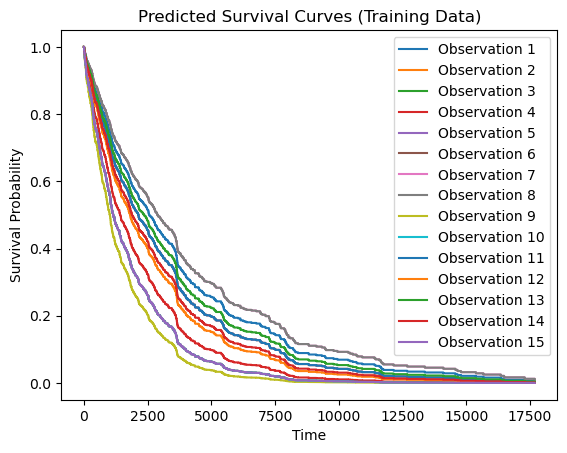

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sksurv.util import Surv
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sklearn.model_selection import train_test_split

# Select the subset of features from X
selected_features = ['whereliv_1.0', 'ptfall_1', 'fpp_info_3', 'whereliv_2.0', 'fpp_info_2', 'fxworried_3.0', 'rsrch_data_use_0.0', 'specialistReferral_2']
X_subset = X[selected_features]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_subset, y, test_size=0.2, random_state=42)

# Convert y_train to a pandas DataFrame
y_train_df = pd.DataFrame.from_records(y_train, columns=["time", "event"])

# Fit the CoxPHSurvivalAnalysis model on the training data
coxph = CoxPHSurvivalAnalysis()
coxph.fit(X_train, Surv.from_dataframe(event="event", time="time", data=y_train_df))

# Predict the survival curves for the training data
predicted_survival = coxph.predict_survival_function(X_train)

# Plot the survival curves for the first 15 samples
num_samples = 15
for i, sf in enumerate(predicted_survival[:num_samples]):
    plt.step(sf.x, sf.y, where="post", label=f"Observation {i+1}")

plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Predicted Survival Curves (Training Data)')
plt.legend()
plt.show()





In [ ]:
from sksurv.nonparametric import kaplan_meier_estimator
from lifelines.utils import concordance_index

# Fit the Kaplan-Meier estimator
time, survival_probs = kaplan_meier_estimator(y['event'], y['time'])

# Get the survival probabilities for each individual data point
individual_survival_probs = survival_probs[np.searchsorted(time, y['time'])]

# Calculate the c-index
c_index = concordance_index(y['time'], -individual_survival_probs, y['event'])
print("Concordance Index:", c_index)
print(survival_probs)


Concordance Index: 1.0
[1.         0.99873737 0.99747475 0.99621212 0.99494949 0.99368687
 0.98989899 0.98863636 0.98737374 0.98358586 0.98232323 0.98106061
 0.97979798 0.97853535 0.97727273 0.9760101  0.97474747 0.97222222
 0.9709596  0.96843434 0.96717172 0.96590909 0.96464646 0.96338384
 0.96212121 0.96085859 0.95833333 0.95707071 0.95580808 0.95328283
 0.94949495 0.94823232 0.94570707 0.94444444 0.94318182 0.94191919
 0.94065657 0.93939394 0.93813131 0.93686869 0.93560606 0.93308081
 0.93181818 0.93055556 0.92929293 0.92676768 0.92550505 0.92424242
 0.9229798  0.92171717 0.92045455 0.91919192 0.91792929 0.91666667
 0.91540404 0.91414141 0.91287879 0.91161616 0.91035354 0.90909091
 0.90656566 0.90530303 0.9040404  0.90277778 0.90025253 0.8989899
 0.89772727 0.89646465 0.89520202 0.89393939 0.89267677 0.89141414
 0.89015152 0.88762626 0.88636364 0.88510101 0.88005051 0.87878788
 0.87752525 0.87626263 0.875      0.87247475 0.87121212 0.86868687
 0.86742424 0.86489899 0.86363636 0.8623